In [1]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal
import numpy as np
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean

In [2]:
gaussian = (0., 1.)
data = normal(loc = gaussian[0], scale=gaussian[1], size=500000)
def f(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3 * x

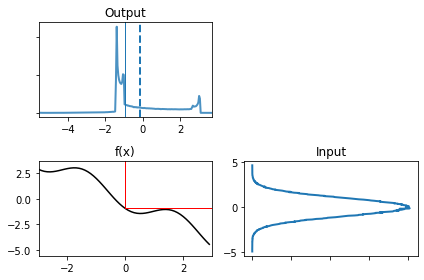

In [3]:
plot_nonlinear_func(data, f)

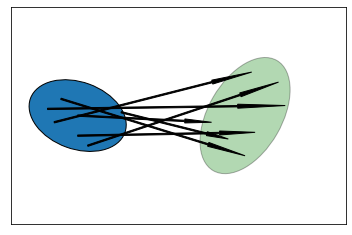

In [4]:
import kf_book.ukf_internal as ukf_internal
ukf_internal.show_2d_transform()

Difference in mean x=-0.054, y=43.266


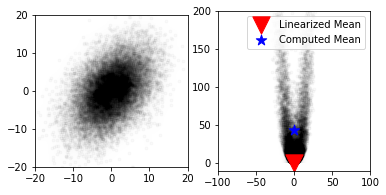

In [5]:
def f_nonlinear_xy(x, y):
    return np.array([x + y, 0.1*x**2 + y*y])

mean = (0.,0.)
P = np.array([[32., 15.],
              [15., 40.]])
mean_fx = f_nonlinear_xy(*mean)

xs, ys = multivariate_normal(mean=mean, cov=P, size=10000).T
plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, mean_fx, "Linearized Mean")

In [6]:
from filterpy.kalman import JulierSigmaPoints

In [7]:
sigmas = JulierSigmaPoints(n=2, kappa=1)

In [8]:
from kf_book.ukf_internal import plot_sigmas

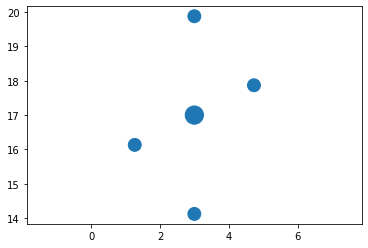

In [9]:
plot_sigmas(sigmas, x=[3, 17], cov=[[1, 0.5], [0.5, 3]])

In [10]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout
def hx(x):
    return x[:1]

In [11]:
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

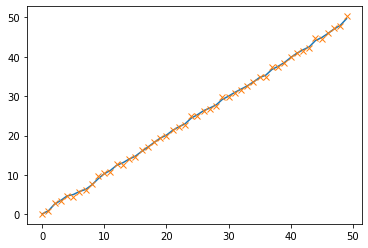

In [12]:
ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P *= 10
ukf.R *= 0.5
ukf.Q = Q_discrete_white_noise(2, dt=1, var=0.03)
zs, xs = [], []
for i in range(50):
    z = i + randn() * 0.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)
plt.plot(xs)
plt.plot(zs, marker="x", ls="")

In [13]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats


Difference in mean x=-0.097, y=0.549


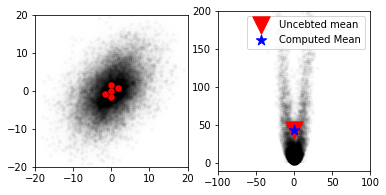

In [15]:
mean = (0., 0.)
p = np.array([[32, 15], [15, 40]])

points = MerweScaledSigmaPoints(n=2, alpha=0.2, beta=2., kappa=0.1)
sigmas = points.sigma_points(mean, p)

sigmas_f = np.empty((5,2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i, 1])
    
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, "Uncebted mean")
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c="r", s=30)


In [18]:
class RadarStation:
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = pos
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std
        
    def reading_of(self, ac_pos):
        diff = np.subtract(ac_pos, self.pos)
        rng = (diff[0] **2 + diff[1]**2) ** 2
        brg = np.atan2(diff[1], diff[0])
        return rng, brg
    
    def noise_reading(self, ac_pose):
        rng,  brg = self.reading_of(ac_pose)
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std
        return rng, brg

In [19]:
class ACSim:
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std
    
    def update(self, dt):
        dx = self.vel * dt + (randn() * self.vel_std) * dt
        self.pos += dx
        return self.pos

In [ ]:
dt = 3
range_std = 5
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
